# NLP Modelling

Using the NLP features engineered in the previous notebook, explore various models to determine whether the tweets contains a disaster. 

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from tqdm import tqdm

# NLP Preprocessing
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# NLP Viz
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer

# Data Modelling
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, recall_score
from sklearn.manifold import TSNE
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import xgboost
from xgboost import XGBClassifier
xgboost.config_context(verbosity=0) # Silect XGBoost

# Monitoring progress
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

nltk.download('stopwords')

config = {
    'test_size': 0.2,
    'CV_splits': 5,
    'seed': 14,
    'n_cores': 16,
    'max_features': 10000
}

/Users/miguelcachosoblechero/opt/anaconda3/envs/Kaggle/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/miguelcachosoblechero/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 0. Load dataset and preprocessing

In [2]:
# Load dataset
input_path = "../input"
raw_tweets = pd.read_csv(os.path.join(input_path, "train.csv")).drop(['id'], axis=1)

# Use Twitter Tokenizer to tokenize tweets
tokenizer = TweetTokenizer()

# Tokenize raw tweets
raw_tweets['twitterTokens'] = raw_tweets.apply(lambda x: tokenizer.tokenize(x.text.lower()), axis=1)

# Remove stop words
english_stopwords = set(stopwords.words('english'))
raw_tweets['twitterTokens_noStop'] = raw_tweets.twitterTokens.apply(lambda x: [i for i in x if i not in english_stopwords])

# Perform stemming
ps = PorterStemmer()
raw_tweets['twitterTokens_Stem'] = raw_tweets.twitterTokens_noStop.apply(lambda x: [ps.stem(i) for i in x])

In [3]:
# Divide between features and labels
X = raw_tweets.drop(['target'], axis=1)
y = raw_tweets.target.values

In [4]:
# CountVectorizer can be used to perform this action in normal text
CountVec = CountVectorizer(stop_words='english', max_features=config['max_features'])
X_bow = CountVec.fit_transform(X.text)

# 1. Data Modeling

This section explores different architectures for text classification, ranging from Classic ML to RNN and CNN1D.

## Classic ML

In [5]:
def run_model_and_evaluate(model, X_train, y_train):
    
    # Instanciate a Cross-Validation model
    cv = StratifiedKFold(n_splits=config['CV_splits'])

    # Create empty results
    conf_matrix = np.zeros((2,2))
    accuracy = []
    recall = []
    auc = []

    # For every split    
    for idx_train, idx_test in tqdm(cv.split(X_train, y_train)):
    
        # Obtain the split indeces
        X_cv, y_cv = X_train[idx_train], y_train[idx_train]

        # Train the models 
        model.fit(X_cv, y_cv)

        # Obtain prediction dataset
        X_cv, y_cv = X_train[idx_test], y_train[idx_test]

        # Predict both models
        model_pred = model.predict(X_cv)

        # Store Confusion Matrix + Accuracy Score + Recall Score + AUC
        conf_matrix += confusion_matrix(y_cv, model_pred)
        accuracy.append(accuracy_score(y_cv, model_pred))
        recall.append(recall_score(y_cv, model_pred))
        auc.append(roc_auc_score(y_cv, model_pred))

    return conf_matrix, accuracy, recall, auc

In [6]:
# Define the target models
dummy_model = DummyClassifier()
svc_model = SVC(kernel='rbf')
naive_model = MultinomialNB()
rf_model = RandomForestClassifier(n_estimators=20, max_depth=50, random_state=config['seed'], n_jobs = config['n_cores'])
xg_model = XGBClassifier(n_estimators=20, max_depth=50, random_state=config['seed'], n_jobs = config['n_cores'])

# Train all models
print(f"-> Training Dummy")
dummy_conf_matrix, dummy_acc, dummy_recall, dummy_auc = run_model_and_evaluate(dummy_model, X_bow, y)
print(f"-> Training SVC")
svc_conf_matrix, svc_acc, svc_recall, svc_auc = run_model_and_evaluate(svc_model, X_bow, y)
print(f"-> Training Multinomial NB")
naive_conf_matrix, naive_acc, naive_recall, naive_auc = run_model_and_evaluate(naive_model, X_bow, y)
print(f"-> Training Random Forest")
rf_conf_matrix, rf_acc, rf_recall, rf_auc = run_model_and_evaluate(rf_model, X_bow, y)
print(f"-> Training XGBoost")
xg_conf_matrix, xg_acc, xg_recall, xg_auc = run_model_and_evaluate(xg_model, X_bow, y)

-> Training Dummy


5it [00:00, 160.25it/s]


-> Training SVC


5it [00:15,  3.02s/it]


-> Training Multinomial NB


5it [00:00, 173.51it/s]


-> Training Random Forest


5it [00:00,  7.55it/s]


-> Training XGBoost


0it [00:00, ?it/s]/Users/miguelcachosoblechero/opt/anaconda3/envs/Kaggle/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:59:24] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


1it [00:00,  2.24it/s]/Users/miguelcachosoblechero/opt/anaconda3/envs/Kaggle/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:59:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2it [00:00,  2.36it/s]/Users/miguelcachosoblechero/opt/anaconda3/envs/Kaggle/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:59:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


3it [00:01,  2.40it/s]/Users/miguelcachosoblechero/opt/anaconda3/envs/Kaggle/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:59:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


4it [00:01,  2.43it/s]/Users/miguelcachosoblechero/opt/anaconda3/envs/Kaggle/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:59:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


5it [00:02,  2.41it/s]


In [7]:
def plot_confusion_matrix(conf_matrix, title):
    
    plt.figure(figsize=(9,8))
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="g")
    plt.xlabel('Predicted'); 
    plt.ylabel('Actual'); 
    plt.title(title)
    plt.show()

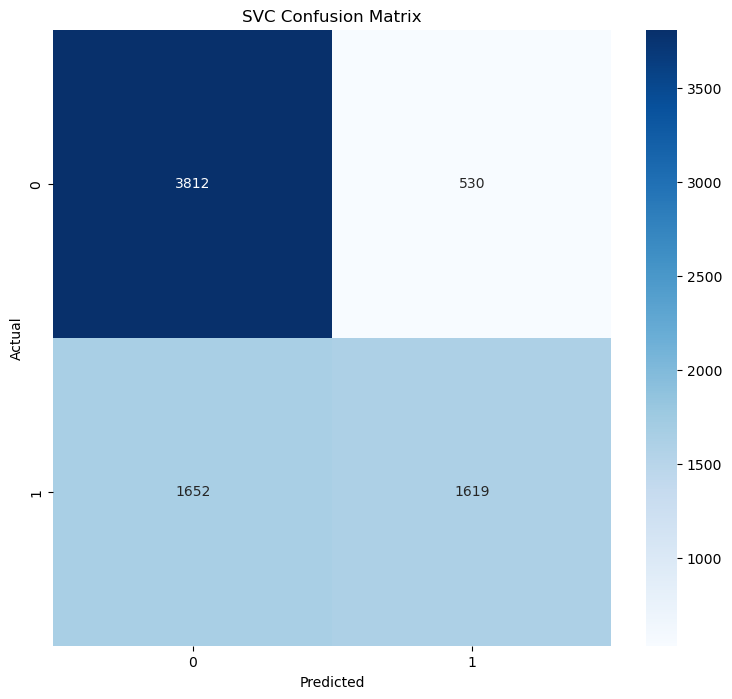

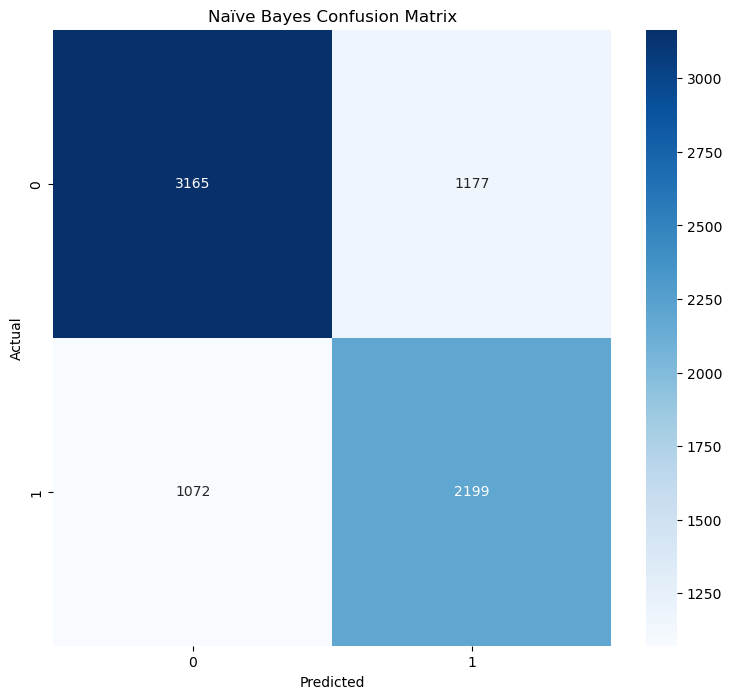

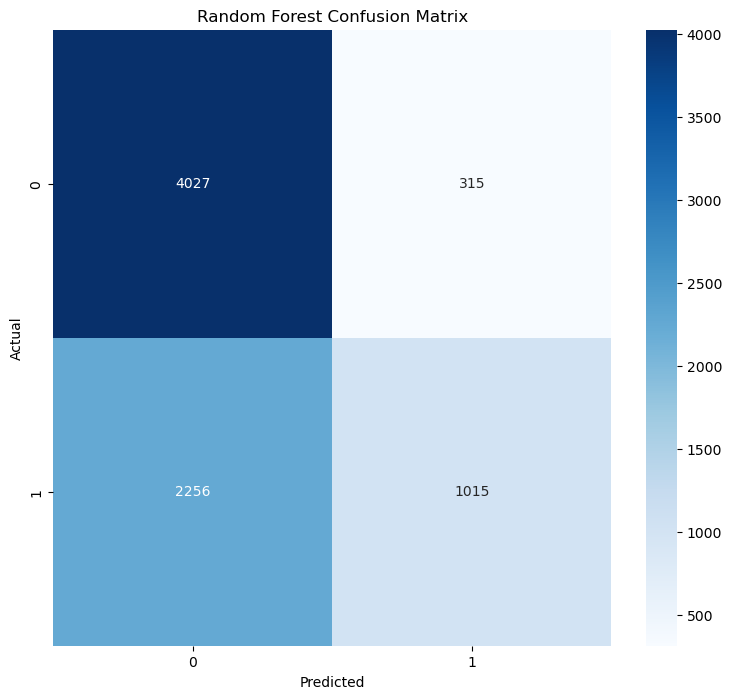

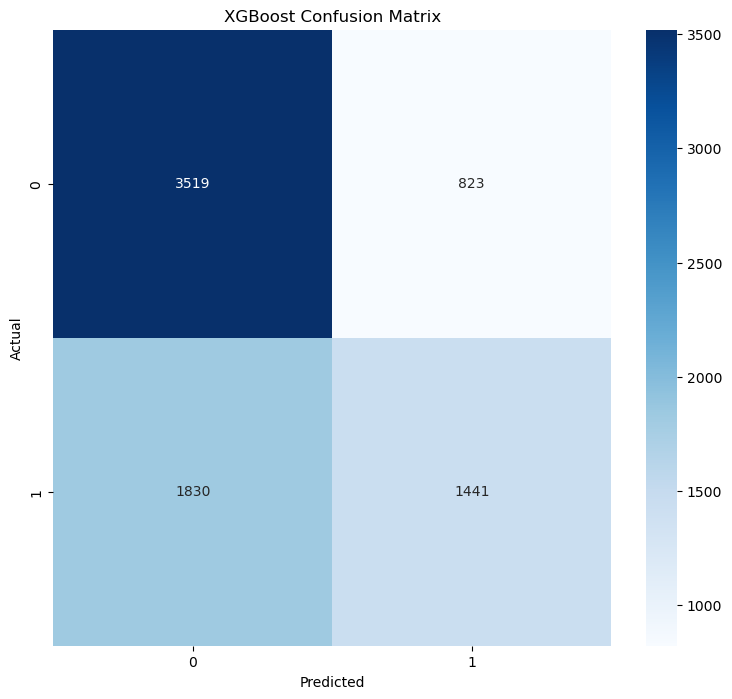

--------------
Accuracy Results
--------------
Null Hypothesis -> 0.5703401975663567
SVC             -> 0.7133962552297104
Naïve Bayes     -> 0.7045893755236181
Random Forest   -> 0.6622937127859031
XGBoost         -> 0.6515263549792365
--------------

--------------
Recall Results
--------------
Null Hypothesis -> [0.0, 0.0, 0.0, 0.0, 0.0]
SVC             -> 0.4949819081635035
Naïve Bayes     -> 0.672306183906436
Random Forest   -> 0.31031258024604896
XGBoost         -> 0.4405523262600089
--------------

--------------
AUC Results
--------------
Null Hypothesis -> 0.5
SVC             -> 0.6864701557702225
Naïve Bayes     -> 0.7006256039247091
Random Forest   -> 0.6188878423600892
XGBoost         -> 0.6255210815435631
--------------


In [8]:
# Analyse the results
# Accuracy
dummy_accuracy_av = sum(dummy_acc)/len(dummy_acc)
svc_accuracy_av = sum(svc_acc)/len(svc_acc)
rf_accuracy_av = sum(rf_acc)/len(rf_acc)
naive_accuracy_av = sum(naive_acc)/len(naive_acc)
xg_accuracy_av = sum(xg_acc)/len(xg_acc)
# Recall
dummy_recall_av = sum(dummy_recall)/len(dummy_recall)
svc_recall_av = sum(svc_recall)/len(svc_recall)
rf_recall_av = sum(rf_recall)/len(rf_recall)
naive_recall_av = sum(naive_recall)/len(naive_recall)
xg_recall_av = sum(xg_recall)/len(xg_recall)
# AUC 
dummy_auc_av = sum(dummy_auc)/len(dummy_auc)
svc_auc_av = sum(svc_auc)/len(svc_auc)
rf_auc_av = sum(rf_auc)/len(rf_auc)
naive_auc_av = sum(naive_auc)/len(naive_auc)
xg_auc_av = sum(xg_auc)/len(xg_auc)

# Display results
# Confusion Matrix
plot_confusion_matrix(svc_conf_matrix, "SVC Confusion Matrix")
plot_confusion_matrix(naive_conf_matrix, "Naïve Bayes Confusion Matrix")
plot_confusion_matrix(rf_conf_matrix, "Random Forest Confusion Matrix")
plot_confusion_matrix(xg_conf_matrix, "XGBoost Confusion Matrix")

print("--------------")
print("Accuracy Results")
print("--------------")
print("Null Hypothesis -> " + str(dummy_accuracy_av))
print("SVC             -> " + str(svc_accuracy_av))
print("Naïve Bayes     -> " + str(naive_accuracy_av))
print("Random Forest   -> " + str(rf_accuracy_av))
print("XGBoost         -> " + str(xg_accuracy_av))
print("--------------")
print("")
print("--------------")
print("Recall Results")
print("--------------")
print("Null Hypothesis -> " + str(dummy_recall))
print("SVC             -> " + str(svc_recall_av))
print("Naïve Bayes     -> " + str(naive_recall_av))
print("Random Forest   -> " + str(rf_recall_av))
print("XGBoost         -> " + str(xg_recall_av))
print("--------------")
print("")
print("--------------")
print("AUC Results")
print("--------------")
print("Null Hypothesis -> " + str(dummy_auc_av))
print("SVC             -> " + str(svc_auc_av))
print("Naïve Bayes     -> " + str(naive_auc_av))
print("Random Forest   -> " + str(rf_auc_av))
print("XGBoost         -> " + str(xg_auc_av))
print("--------------")